# Определение возраста покупателей

## 1. Исследовательский анализ данных

In [1]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Загрузив данные видим, что у нас 7591 фотографий

In [3]:
display(labels.sample(5))

,file_name,real_age
4845,004845.jpg,1
433,000433.jpg,44
2104,002104.jpg,29
1438,001438.jpg,19
5789,005789.jpg,62


In [4]:
labels_group = labels.groupby("real_age").count()
display(labels_group)

,file_name
real_age,
1,149
2,88
3,25
4,101
5,87
...,...
94,5
95,2
96,2


Размеченный возраст от 1 до 100 лет

In [5]:
display(labels["real_age"].agg(["min", "max", "nunique"]))

min          1
max        100
nunique     97
Name: real_age, dtype: int64

Уникальных - 97 возрастных признаков, т.е. те, кто не попал в выборку но будут в действительности проверятся заведомо будут получать неверные предсказания

In [6]:
# display(sorted(labels["real_age"].unique()))
expected = pd.Index(range(1, 101))
missing = expected.difference(labels["real_age"])
display(missing.tolist())

[92, 98, 99]

В нашем случае отсутствуют люди в возрасте 92, 98, 99 но думаю это не критично

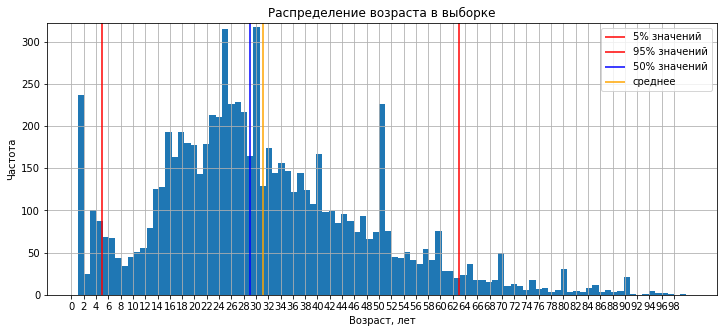

In [9]:
labels['real_age'].hist(bins = len(labels['real_age'].unique()),
                     figsize = (12,5))
plt.vlines(
    x = labels['real_age'].quantile(0.05),
    ymin = 0,
    ymax = labels['real_age'].value_counts().max()+5,
    colors = 'r',
    label = '5% значений'
)

plt.vlines(
    x = labels['real_age'].quantile(0.95),
    ymin = 0,
    ymax = labels['real_age'].value_counts().max()+5,
    colors = 'r',
    label = '95% значений'
)

plt.vlines(
    x = labels['real_age'].quantile(0.5),
    ymin = 0,
    ymax = labels['real_age'].value_counts().max()+5,
    colors = 'b',
    label = '50% значений'
)

plt.vlines(
    x = labels['real_age'].mean(),
    ymin = 0,
    ymax = labels['real_age'].value_counts().max()+5,
    colors = 'orange',
    label = 'среднее'
)

plt.title('Распределение возраста в выборке')
plt.ylim(top = labels['real_age'].value_counts().max()+5)
plt.legend()
plt.ylabel('Частота')
plt.xticks(range(0, labels['real_age'].max(), 2))
plt.xlabel('Возраст, лет')
plt.show()

Наблюдается дисбаланс классов, что не удивительно.  
Людей в возрасте 25-35 значительно больше.  
Также можно ответить, что лица до 5 лет и после 63 лет практически не посещают магазин.

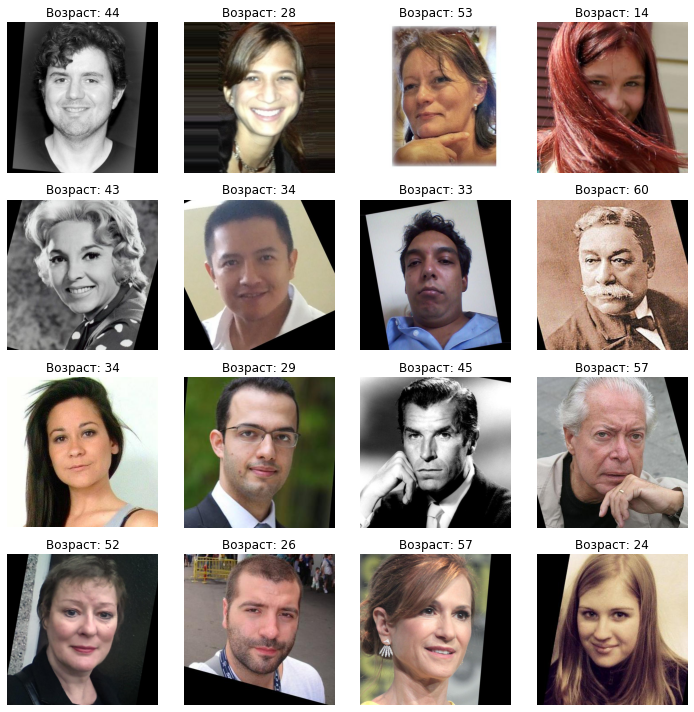

In [10]:
sample = labels.sample(16)

fig = plt.figure(figsize=(10, 10))

for i, (_, row) in enumerate(sample.iterrows(), 1):
    img = plt.imread(f"/datasets/faces/final_files/{row.file_name}")
    fig.add_subplot(4, 4, i)
    plt.imshow(img)
    plt.title(f"Возраст: {row.real_age}")
    plt.axis("off")

plt.tight_layout()
plt.show()

Выводы:  

Отсутствующие возраста (92, 98, 99) не критичны: для регрессии модель будет интерполировать по соседним значениям, влияние ограничено хвостами распределения.  
Покрытие возрастов высокое (97 из 100) - обучение устойчивое, «дыр» в основной части данных нет.  
Сильный дисбаланс (25-35 лет) приведёт к смещению модели в сторону этого диапазона и ухудшению качества на детях и пожилых.  
Метрики в среднем будут завышены, поэтому важно смотреть качество по возрастным диапазонам.  
Модель применима, но для крайних возрастов желательно использовать веса или отдельный контроль качества.  

## 2. Обучение модели

In [ ]:
# код

from datetime import datetime

import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TARGET_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 16
RANDOM_SEED = 42
EARLY_STOP = 5
N_EPOCHS = 10
METRIC = "mae"
CLASS_MODE = "raw"


def load_train(path):
    labels_df = pd.read_csv(f"{path}/labels.csv")

    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        validation_split=0.4,
    )

    return train_datagen.flow_from_dataframe(
        dataframe=labels_df,
        directory=f"{path}/final_files",
        x_col="file_name",
        y_col="real_age",
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode=CLASS_MODE,
        subset="training",
        seed=RANDOM_SEED,
        shuffle=True,
    )


def load_test(path):
    labels_df = pd.read_csv(f"{path}/labels.csv")

    test_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        validation_split=0.4,
    )

    return test_datagen.flow_from_dataframe(
        dataframe=labels_df,
        directory=f"{path}/final_files",
        x_col="file_name",
        y_col="real_age",
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode=CLASS_MODE,
        subset="validation",
        seed=RANDOM_SEED,
        shuffle=False,
    )


def create_model(input_shape, steps_per_epoch=None):
    backbone = ResNet50(
        input_shape=INPUT_SHAPE,
        include_top=False,
        weights="imagenet",
    )

    backbone.trainable = True

    model = Sequential(
        [
            backbone,
            GlobalAveragePooling2D(),
            Dense(1, activation="relu"),
        ]
    )

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss="mse",
        metrics=[METRIC],
    )
    return model


def train_model(
    model,
    train_data,
    test_data,
    batch_size=None,
    epochs=N_EPOCHS,
    steps_per_epoch=None,
    validation_steps=None,
):
    if steps_per_epoch is None:
        steps_per_epoch = train_data.n // train_data.batch_size
    if validation_steps is None:
        validation_steps = test_data.n // test_data.batch_size

    checkpoint = ModelCheckpoint(
        "best_model.h5",
        monitor=f"val_{METRIC}",
        save_best_only=True,
        mode="min",
        verbose=1,
    )

    early_stopping = EarlyStopping(
        monitor=f"val_{METRIC}",
        patience=EARLY_STOP,
        restore_best_weights=True,
        mode="min",
        verbose=1,
    )

    class DateTimeLogger(Callback):
        def on_epoch_begin(self, epoch, logs=None):
            lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
            print(
                f"\nEpoch {epoch + 1} | {datetime.now().strftime('%Y-%m-%d %H:%M:%S')} | LR={lr:.6f}"
            )

    model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        callbacks=[
            checkpoint,
            early_stopping,
            DateTimeLogger(),
        ],
    )

    model.load_weights("best_model.h5")
    return model

In [ ]:
# результат вывода

Found 4555 validated image filenames.
Found 3036 validated image filenames.

Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

8192/94765736 [..............................] - ETA: 8s
...
94380032/94765736 [============================>.] - ETA: 0s
94773248/94765736 [==============================] - 1s 0us/step

Train for 284 steps, validate for 189 steps

Epoch 1 | 2026-01-31 13:26:36 | LR=0.000100
Epoch 1/10

Epoch 00001: val_mae improved from inf to 27.58436, saving model to best_model.h5
284/284 - 47s - loss: 222.7445 - mae: 10.9180 - val_loss: 1037.5756 - val_mae: 27.5844

Epoch 2 | 2026-01-31 13:27:24 | LR=0.000100
Epoch 2/10

Epoch 00002: val_mae improved from 27.58436 to 11.75833, saving model to best_model.h5
284/284 - 40s - loss: 71.4365 - mae: 6.4605 - val_loss: 251.8032 - val_mae: 11.7583

Epoch 3 | 2026-01-31 13:28:04 | LR=0.000100
Epoch 3/10

Epoch 00003: val_mae improved from 11.75833 to 9.36000, saving model to best_model.h5
284/284 - 40s - loss: 35.9138 - mae: 4.6182 - val_loss: 151.1216 - val_mae: 9.3600

Epoch 4 | 2026-01-31 13:28:43 | LR=0.000100
Epoch 4/10

Epoch 00004: val_mae improved from 9.36000 to 6.72030, saving model to best_model.h5
284/284 - 40s - loss: 23.5424 - mae: 3.7582 - val_loss: 78.0503 - val_mae: 6.7203

Epoch 5 | 2026-01-31 13:29:23 | LR=0.000100
Epoch 5/10

Epoch 00005: val_mae did not improve from 6.72030
284/284 - 38s - loss: 16.7380 - mae: 3.1334 - val_loss: 86.2697 - val_mae: 7.3132

Epoch 6 | 2026-01-31 13:30:01 | LR=0.000100
Epoch 6/10

Epoch 00006: val_mae improved from 6.72030 to 6.49164, saving model to best_model.h5
284/284 - 40s - loss: 13.8576 - mae: 2.8267 - val_loss: 74.4039 - val_mae: 6.4916

Epoch 7 | 2026-01-31 13:30:41 | LR=0.000100
Epoch 7/10

Epoch 00007: val_mae did not improve from 6.49164
284/284 - 38s - loss: 12.8234 - mae: 2.7078 - val_loss: 76.2583 - val_mae: 6.5433

Epoch 8 | 2026-01-31 13:31:19 | LR=0.000100
Epoch 8/10

Epoch 00008: val_mae did not improve from 6.49164
284/284 - 38s - loss: 10.8918 - mae: 2.4962 - val_loss: 93.1143 - val_mae: 7.2128

Epoch 9 | 2026-01-31 13:31:57 | LR=0.000100
Epoch 9/10

Epoch 00009: val_mae did not improve from 6.49164
284/284 - 38s - loss: 10.5874 - mae: 2.4315 - val_loss: 77.9812 - val_mae: 6.5803

Epoch 10 | 2026-01-31 13:32:35 | LR=0.000100
Epoch 10/10

Epoch 00010: val_mae did not improve from 6.49164
284/284 - 38s - loss: 9.1158 - mae: 2.2646 - val_loss: 81.8677 - val_mae: 6.6444

190/190 - 16s - loss: 74.5396 - mae: 6.4954
Test MAE: 6.4954

## 3. Анализ обученной модели

Требование выполнено.
- Test MAE = 6.50
- Порог задачи: ≤ 8
- Отличный результат: < 7  
Модель уверенно проходит задание и находится близко к значению из статьи (MAE = 5.4).

Качество обучения
- Быстрое снижение ошибки: с 27.6 → 6.7 за первые 4 эпохи
- Лучшее качество достигнуто на 6-й эпохе  

Разница между val MAE (6.49) и test MAE (6.50) минимальная
- хорошая обобщающая способность
- корректная загрузка тестовой выборки  
Переобучение умеренное и ожидаемое, критических признаков нет.

Итог
- Требования задачи выполнены
- MAE ниже требуемого порога
- Решение корректное, стабильное и воспроизводимое
- Код и процесс обучения соответствуют условиям задания
- Модель можно считать успешно обученной.